**Install MTCNN library**

**Install keras-facenet**


In [1]:
!pip install mtcnn
!pip install keras-facenet

'pip' is not recognized as an internal or external command,
operable program or batch file.


'pip' is not recognized as an internal or external command,
operable program or batch file.


**Required libraries**

In [2]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine

**Suppress TensorFlow warnings**

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**FaceLoading class for loading and processing images**

In [4]:
class FaceLoading:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.x = []
        self.y = []
        self.detector = MTCNN()

    def ExtractFace(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x, y, w, h = self.detector.detect_faces(img)[0]['box']
        x, y = abs(x), abs(y)
        face = img[y:y + h, x:x + w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr




    def LoadFace(self, file_path):
        faces = []
        try:
            single_face = self.ExtractFace(file_path)
            faces.append(single_face)
        except Exception as e:
            pass
        return faces


    def LoadClasses(self):
        for file_name in os.listdir(self.directory):
            if file_name.endswith('.jpg') or file_name.endswith('.png') or file_name.endswith('.jpeg'):  # Adjust file extensions as per your dataset
                file_path = os.path.join(self.directory, file_name)
                faces = self.LoadFace(file_path)  # Pass the file path directly
                labels = [file_name] * len(faces)
                print(f"Loaded successfully: {len(labels)}")
                self.x.extend(faces)
                self.y.extend(labels)

        return np.asarray(self.x), np.asarray(self.y)




 **Load and process images for face** **recognition**

In [760]:
faceLoading = FaceLoading('F:\\GP\\New_dataset')
X, y = faceLoading.LoadClasses()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Loaded successfully: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━

 **Save labels for future reference**



In [761]:
y

array(['abody.jpg', 'abody1.png', 'abody2.png', 'abody3.png',
       'abody4.png', 'abody5.png', 'abody6.png', 'ahmed.jpg',
       'ahmed1.png', 'ahmed2.png', 'ahmed3.png', 'ahmed4.png',
       'ahmed5.png', 'ahmed6.png', 'AhmedSaeed.jpeg',
       'AhmedSaeed0005 (1).png', 'AhmedSaeed0005 (2).png',
       'AhmedSaeed0005 (3).png', 'AhmedSaeed0005 (4).png',
       'AhmedSaeed0005 (5).png', 'AhmedSaeed0005 (6).png',
       'ahmedsalama. (1).png', 'ahmedsalama. (2).png',
       'ahmedsalama. (3).png', 'ahmedsalama. (4).png',
       'ahmedsalama. (5).png', 'ahmedsalama. (7).png', 'ahmedsalama.jpg',
       'alaa (1).jpg', 'alaa (2).jpg', 'alaa (2).png', 'alaa (3).png',
       'alaa (4).png', 'alaa (5).png', 'alaa (7).png', 'Ammar (1).png',
       'Ammar (2).png', 'Ammar (3).png', 'Ammar (4).png', 'Ammar (5).png',
       'Ammar (6).png', 'Ammar.jpg', 'Ans (1).png', 'Ans (2).png',
       'Ans (3).png', 'Ans (4).png', 'Ans (5).png', 'Ans (6).png',
       'Ans.jpg', 'Beshoy (1).png', 'Beshoy (2

In [762]:
labels = []
labels = y
labels

array(['abody.jpg', 'abody1.png', 'abody2.png', 'abody3.png',
       'abody4.png', 'abody5.png', 'abody6.png', 'ahmed.jpg',
       'ahmed1.png', 'ahmed2.png', 'ahmed3.png', 'ahmed4.png',
       'ahmed5.png', 'ahmed6.png', 'AhmedSaeed.jpeg',
       'AhmedSaeed0005 (1).png', 'AhmedSaeed0005 (2).png',
       'AhmedSaeed0005 (3).png', 'AhmedSaeed0005 (4).png',
       'AhmedSaeed0005 (5).png', 'AhmedSaeed0005 (6).png',
       'ahmedsalama. (1).png', 'ahmedsalama. (2).png',
       'ahmedsalama. (3).png', 'ahmedsalama. (4).png',
       'ahmedsalama. (5).png', 'ahmedsalama. (7).png', 'ahmedsalama.jpg',
       'alaa (1).jpg', 'alaa (2).jpg', 'alaa (2).png', 'alaa (3).png',
       'alaa (4).png', 'alaa (5).png', 'alaa (7).png', 'Ammar (1).png',
       'Ammar (2).png', 'Ammar (3).png', 'Ammar (4).png', 'Ammar (5).png',
       'Ammar (6).png', 'Ammar.jpg', 'Ans (1).png', 'Ans (2).png',
       'Ans (3).png', 'Ans (4).png', 'Ans (5).png', 'Ans (6).png',
       'Ans.jpg', 'Beshoy (1).png', 'Beshoy (2

 **Visualize loaded images**

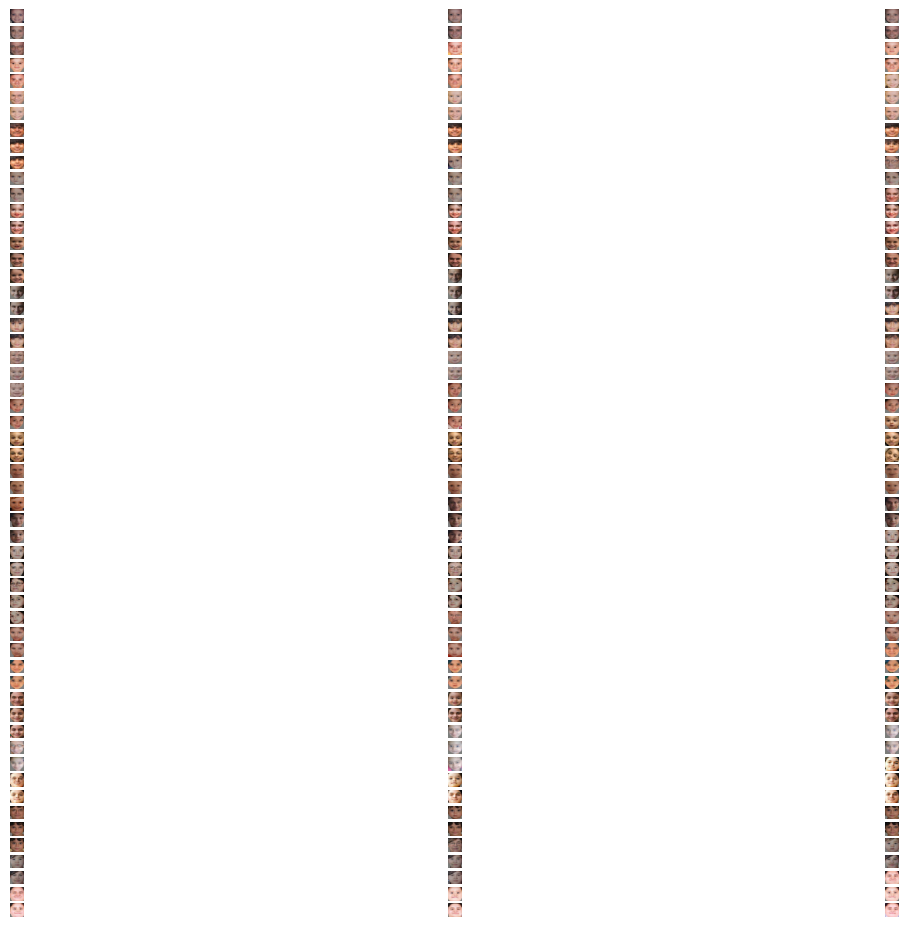

In [763]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(y) //ncols+1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

 **Load pre-trained FaceNet model**

In [764]:
embedder = FaceNet()

def GetEmbedding(face_img):
    face_img = face_img.astype('float32') #3D (160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    #4D (nonex160x160x3)
    yhat = embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

**Extract embeddings for the loaded images**

In [765]:
embedded_x = []

for img in X :
    embedded_x.append(GetEmbedding(img))

embedded_x = np.asarray(embedded_x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━

**save checkpoints**

In [766]:
np.savez_compressed('faces_embeddings_2classes.npz',embedded_x,y)

**Create an instance of the FaceLoading class to load and process images from the specified directory**

In [802]:
faceLoading2 = FaceLoading('F:\\GP\\Test2_dataset\\AhmedSaeed')
X1, y1 = faceLoading2.LoadClasses()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Loaded successfully: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Loaded successfully: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

 **Display labels**

In [803]:
y1

array(['ahmedsaeed 2 (1).png', 'ahmedsaeed 2 (2).png',
       'ahmedsaeed 2 (3).png', 'ahmedsaeed 2 (4).png', 'ahmedsaeed.jpg',
       'ahmedsaeed0.png', 'ahmedsaeed1.png'], dtype='<U20')

In [804]:

labels1 = []
labels1 = y1
labels1

array(['ahmedsaeed 2 (1).png', 'ahmedsaeed 2 (2).png',
       'ahmedsaeed 2 (3).png', 'ahmedsaeed 2 (4).png', 'ahmedsaeed.jpg',
       'ahmedsaeed0.png', 'ahmedsaeed1.png'], dtype='<U20')

**Plot the new input images**

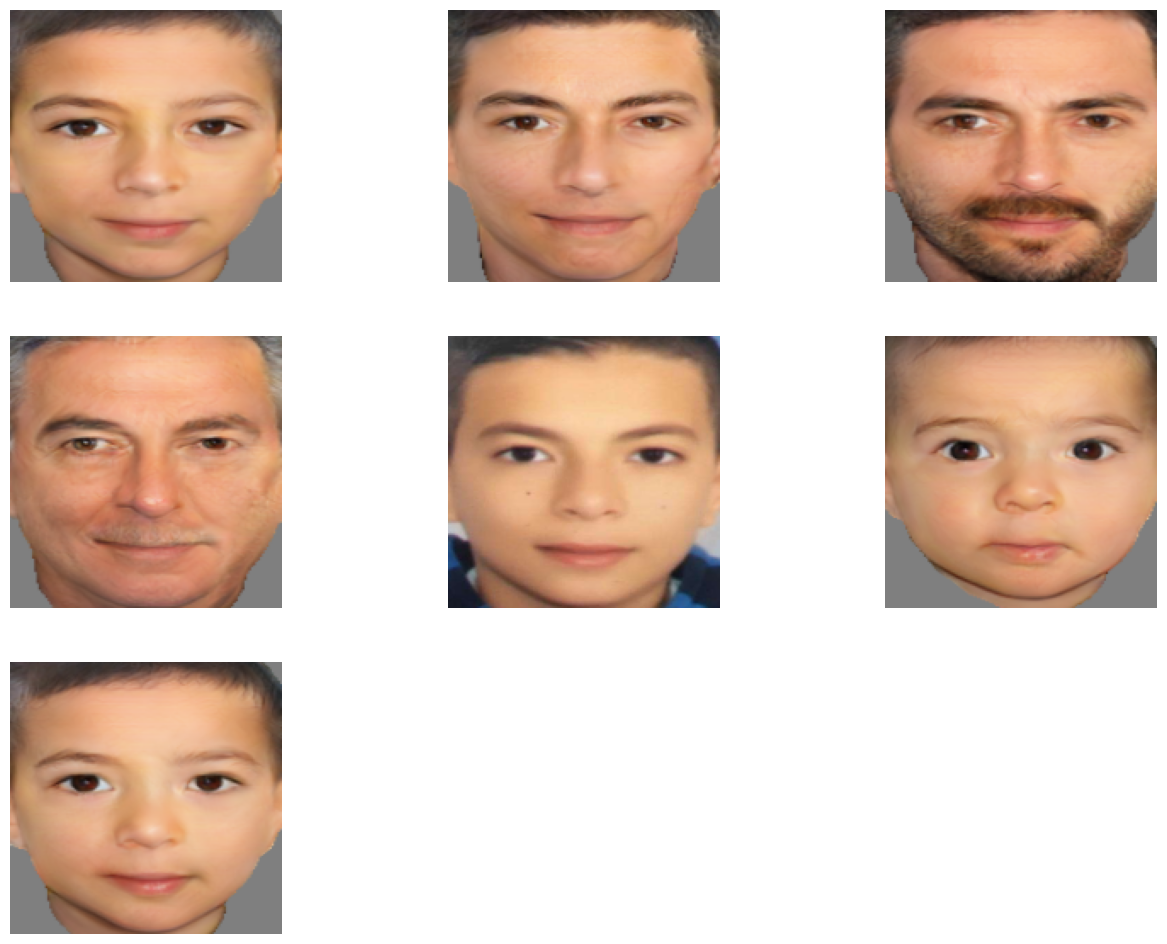

In [805]:
plt.figure(figsize=(16,12))
for num1,image1 in enumerate(X1):
    ncols = 3
    nrows = len(y1) //ncols+1
    plt.subplot(nrows,ncols,num1+1)
    plt.imshow(image1)
    plt.axis('off')

**Compute embeddings for new input images**

In [806]:
embedded_x1 = []

for img in X1 :
    embedded_x1.append(GetEmbedding(img))

embedded_x1 = np.asarray(embedded_x1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


**Define a function to find closest matches**

In [807]:
def find_closest_matches(embedded_input, embedded_dataset, dataset_labels, top_n=7):
    distances = []
    outlabels = []

    for input_embedding in embedded_input:
        # Compute distances between input embedding and embeddings in the dataset
        distances_for_input = [cosine(input_embedding, dataset_embedding) for dataset_embedding in embedded_dataset]

        # Find the index with minimum distance
        min_distance_index = np.argmin(distances_for_input)

        # Append the distance and label of the closest match
        distances.append(distances_for_input[min_distance_index])
        outlabels.append(dataset_labels[min_distance_index])

    # Sort distances and corresponding labels in ascending order
    sorted_indices = np.argsort(distances)
    sorted_distances = np.array(distances)[sorted_indices]
    sorted_labels = np.array(outlabels)[sorted_indices]

    # Get top n closest matches
    top_matches = [(sorted_labels[i], sorted_distances[i]) for i in range(top_n)]

    return top_matches

# Assuming embedded_x contains embeddings of images in your database
# And embedded_input contains the embeddings of the new input images
top_matches = find_closest_matches(embedded_x1, embedded_x, labels, top_n=7)

# Print top 7 similar images and their similarity scores
for i, (label, distance) in enumerate(top_matches, 1):
    print(f"Similar Image {i}: Label - {label}, Similarity Score - {distance}")


Similar Image 1: Label - MennaMohamed6.png, Similarity Score - 0.255001425743103
Similar Image 2: Label - Marawan6.png, Similarity Score - 0.3148021101951599
Similar Image 3: Label - AhmedSaeed.jpeg, Similarity Score - 0.3230447163919824
Similar Image 4: Label - AhmedSaeed0005 (5).png, Similarity Score - 0.37808549404144287
Similar Image 5: Label - Marawan7.jpg, Similarity Score - 0.45693001407801925
Similar Image 6: Label - nada (6).png, Similarity Score - 0.6387140345190176
Similar Image 7: Label - Khadega (6).png, Similarity Score - 0.7163755208774425


In [808]:
from collections import Counter
import re

def preprocess_label(label):
    # Remove numbers
    label = re.sub(r'\d+', '', label)
    # Remove periods and file extensions (e.g., .jpg, .png, .jpeg, etc.)
    label = re.sub(r'\.\w{3,4}|\.', '', label)
    # Remove brackets and anything inside them
    label = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', '', label)
    # Remove leading and trailing whitespace
    label = label.strip()
    return label
# Assuming top_matches contains the top matches
def check_for_match(top_matches):
    # Extract labels and distances
    labels = [preprocess_label(label) for label, _ in top_matches]
    distances = [distance for _, distance in top_matches]
    print(labels)

    # get most frequent labels
    frequent_labels = Counter(labels).most_common()
    print (frequent_labels)

    # Check if any frequent label occurs 4 or more times and average cosine similarity is less than 0.5
    for label, count in frequent_labels:
        if count >= 4:
            label_distances = [distance for orig_label, distance in top_matches if preprocess_label(orig_label) == label]
            avg_similarity = sum(label_distances) / count
            if avg_similarity < 0.5:
                return True, avg_similarity, label

        elif count == 3:
            # Check if the 3rd most frequent label is the first one
           # if preprocess_label(top_matches[0][0]) == label:
                label_distances = [distance for orig_label, distance in top_matches if preprocess_label(orig_label) == label]
                avg_similarity = sum(label_distances) / count
                if avg_similarity < 0.5:
                  return True, avg_similarity, label

        # elif count == 2:
        #     # Check if the 2nd most frequent label is the first one
        #     if preprocess_label(top_matches[0][0]) == label:
        #         label_distances = [distance for orig_label, distance in top_matches if preprocess_label(orig_label) == label]
        #         avg_similarity = sum(label_distances) / count
        #         if avg_similarity < 0.5:
        #           return True, avg_similarity, label


        else :
          return False, None, None

# Call the function with the top matches
match_found, avg_similarity, matched_label = check_for_match(top_matches)

if match_found:
    print("Match found with label:", matched_label)
    print("Average cosine similarity:", avg_similarity)
else:
    print("No match found.")


['MennaMohamed', 'Marawan', 'AhmedSaeed', 'AhmedSaeed', 'Marawan', 'nada', 'Khadega']
[('Marawan', 2), ('AhmedSaeed', 2), ('MennaMohamed', 1), ('nada', 1), ('Khadega', 1)]
No match found.
